# Question 1 Part-1

## Importing libraries


In [1]:
import numpy as np
import pandas as pd
import math as mt
import codecs, json 
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## Utility Functions

NeuralNetwork class

In [16]:
class NeuralNetwork:
    def __init__(self,input_size,output_size, node_list , activation = "sigmoid"):
        self.input_LS = input_size
        self.hidden_LS = node_list
        self.output_LS = output_size
        self.No_HLayers = len(node_list) 
        self.W = np.empty(self.No_HLayers + 1, dtype = object)
        self.B = np.empty(self.No_HLayers + 1, dtype = object)
        self.H_in = np.empty(self.No_HLayers + 1, dtype = object)
        self.H_out = np.empty(self.No_HLayers + 2, dtype = object)
        self.w_grad = np.empty(self.No_HLayers + 1, dtype = object)
        self.b_grad = np.empty(self.No_HLayers + 1, dtype = object)
        bound = np.sqrt(1./self.input_LS)
        self.W[0] = np.random.uniform(-bound,bound,(self.input_LS, self.hidden_LS[0]))
        self.B[0] = np.random.uniform(-bound,bound,(1, self.hidden_LS[0]))
        for i in range(1, len(self.W)-1):
            self.W[i] = np.random.uniform(-bound,bound,(self.hidden_LS[i-1], self.hidden_LS[i]))
            self.B[i] = np.random.uniform(-bound,bound,(1, self.hidden_LS[i]))  
        self.W[len(self.W)-1] = np.random.uniform(-bound,bound,(self.hidden_LS[len(self.W)-2],self.output_LS))
        self.B[len(self.B)-1] = np.random.uniform(-bound,bound,(1, self.output_LS))
        self.activation = activation
        
        
    def save_metaData(self, fileName):
        data = {"no_of_hidden_layers":self.No_HLayers,"no_of_neurons_per_layer":self.hidden_LS,"activation":self.activation,"weights": self.W, "bais": self.B}
        np.save('./../output_data/'+fileName+'.npy',data)

    def load_metaData(self,fileName):
        try:
            data_loaded = np.load('./../output_data/'+fileName+'.npy')
            self.activation = data_loaded[()]["activation"] 
            self.W = data_loaded[()]["weights"] 
            self.B = data_loaded[()]["bais"]
        except:
            pass
        
    def ReLU(self, z):
        return z * (z > 0)

    def delta_ReLU(self, z):
        return 1. * (z > 0)
    
    def tanh(self, z):
        return np.tanh(z)

    def delta_tanh(self, z):
        return 1. - z * z
    
    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))
    
    def delta_sigmoid(self, z):
        return self.sigmoid(z) *(1-self.sigmoid (z))
    
    def linear(self, z):
        return z
    
    def delta_linear(self,z):
        return np.ones(z.shape)

    
    def softmax(self, y_hat):
        tmp = y_hat - y_hat.max(axis=1).reshape(-1, 1)
        exp_tmp = np.exp(tmp)
        return exp_tmp / exp_tmp.sum(axis=1).reshape(-1, 1)
    
    
    def forwardprop(self, X):
        self.H_out[0] = X
        for i in range(0,len(self.W)):
            self.H_in[i] = np.dot(self.H_out[i], self.W[i]) + self.B[i]
            if self.activation == "sigmoid":
                self.H_out[i + 1] = self.sigmoid(self.H_in[i])
            elif self.activation == "ReLU": 
                self.H_out[i + 1] = self.ReLU(self.H_in[i])
            elif self.activation == "tanh": 
                self.H_out[i + 1] = self.tanh(self.H_in[i])
            elif self.activation == "linear": 
                self.H_out[i + 1] = self.linear(self.H_in[i])
#             print("h_out[",i + 1,"].shape",self.H_out[i+1].shape)
#             print("h_out[",i + 1,"]",self.H_out[i+1])
#         print("h_out[",len(self.W)/2,"].shape",self.H_out[int(len(self.W)/2)].shape)
#         print("h_out[",len(self.W)/2,"]",self.H_out[int(len(self.W)/2)])
            
        self.yHat = self.H_out[len(self.W)]
        return self.yHat , self.H_out[int(len(self.hidden_LS)//2) + 1]

    def backprop(self, X, yHat, error, LR = 0.01):  
        m = X.shape[0]
        err2 = error
        if self.activation == "sigmoid":
            err2 *= self.delta_sigmoid(yHat)
        elif self.activation == "ReLU": 
            err2 *= self.delta_ReLU(yHat)
        elif self.activation == "tanh": 
            err2 *= self.delta_tanh(yHat)
        elif self.activation == "linear": 
            err2 *= self.delta_linear(yHat)
        for i in range(len(self.w_grad) - 1, -1, -1):
            self.w_grad[i] = LR * np.dot(self.H_out[i].T,err2)/m
            self.b_grad[i] = LR * np.average(err2, axis=0)
            err2 = np.dot(err2, self.W[i].T)
            if self.activation == "sigmoid":
                err2 *= self.delta_sigmoid(self.H_out[i])
            elif self.activation == "ReLU": 
                err2 *= self.delta_ReLU(self.H_out[i])
            elif self.activation == "tanh": 
                err2 *= self.delta_tanh(self.H_out[i]) 
            elif self.activation == "linear": 
                err2 *= self.delta_linear(self.H_out[i])
#         self.w_grad[0] = LR * np.dot(self.H_out[0].T, err2)/m
#         self.b_grad[0] = LR * np.average(err2, axis=0)

    def grad_update(self):
        self.W += self.w_grad
        self.B += self.b_grad
        
    def fit(self, X, y, epoch = 10, LR = 0.01, cost_check = False, batch = False, batch_size = -1, savefile = False):
        cost = [] 
        if batch_size == -1:
            batch_size = X.shape[0]
            batch = False
        XList = []
        yList = []
        if batch:
            XList = [X[i : i + batch_size][:] for i in range(0,X.shape[0], batch_size)]
            yList = [y[i : i + batch_size][:] for i in range(0,y.shape[0], batch_size)]    
        else:
            XList.append(X)
            yList.append(y)
        
        for i in range(epoch):
            itr = 0
            y_hatList = []
            res_list = np.empty([0, self.hidden_LS[int(len(self.hidden_LS)//2)]])
            for XL,yL in zip(XList, yList):
                y_hat , result = self.forwardprop(XL)
                error = yL - y_hat
                res_list = np.concatenate((res_list, result), 0)
                self.backprop(XL, y_hat, error, LR)
                self.grad_update()
                y_hatList += list(y_hat)
                print("epoch: ",i ,"iteration: ",itr)
                itr += 1
            if cost_check:
#                 y_hatList = np.clip(y_hatList, 0.00001, 0.99999)
                cost.append(mean_squared_error(y,y_hatList))
                print("cost[",i,"]: " , cost[i])
        if savefile:
            self.save_metaData(self.activation)
        return cost, res_list
    
    def predict(self, X, loadfile = False):
        if loadfile:
            self.load_metaData(self.activation) 
        y_hat = self.forwardprop(X)
        return np.argmax(y_hat, axis=1)
        
            

In [17]:
def save_to_csv(res_list,filename):
    resDF = pd.DataFrame(res_list)
    resDF[Class] = y
    resDF.to_csv("./../output_data/"+filename+".csv")

### Reading the Data Set


In [18]:
output_file = "./../input_data/data.csv"
dataSet = pd.read_csv(output_file)
Class = "xAttack"
columns = list(dataSet.columns)
X = dataSet[columns[:-1]].values
y = dataSet[[Class]].values
X = StandardScaler().fit_transform(X)
# X, y

In [104]:
node_list = [14]
NN = NeuralNetwork(X.shape[1] , X.shape[1], node_list, activation = "linear")

### Fitting the model
#### NN.fit(Feature set, output class, epoch = 10, Learning Rate = 0.01, cost_check = False, batch = False, batch_size = -1, savefile=False)
* For best results use NN.fit(Feature set, output class, epoch = 1000, Learning Rate = 0.1, cost_check=True, batch = True, batch_size = 500, savefile=True)

In [105]:
costs, res_list = NN.fit(X, X, 100, 0.01, cost_check=True, batch = True, batch_size = 512)

epoch:  0 iteration:  0
epoch:  0 iteration:  1
epoch:  0 iteration:  2
epoch:  0 iteration:  3
epoch:  0 iteration:  4
epoch:  0 iteration:  5
epoch:  0 iteration:  6
epoch:  0 iteration:  7
epoch:  0 iteration:  8
epoch:  0 iteration:  9
epoch:  0 iteration:  10
epoch:  0 iteration:  11
epoch:  0 iteration:  12
epoch:  0 iteration:  13
epoch:  0 iteration:  14
epoch:  0 iteration:  15
epoch:  0 iteration:  16
epoch:  0 iteration:  17
epoch:  0 iteration:  18
epoch:  0 iteration:  19
epoch:  0 iteration:  20
epoch:  0 iteration:  21
epoch:  0 iteration:  22
epoch:  0 iteration:  23
epoch:  0 iteration:  24
epoch:  0 iteration:  25
epoch:  0 iteration:  26
epoch:  0 iteration:  27
epoch:  0 iteration:  28
epoch:  0 iteration:  29
epoch:  0 iteration:  30
epoch:  0 iteration:  31
epoch:  0 iteration:  32
epoch:  0 iteration:  33
epoch:  0 iteration:  34
epoch:  0 iteration:  35
epoch:  0 iteration:  36
epoch:  0 iteration:  37
epoch:  0 iteration:  38
epoch:  0 iteration:  39
epoch:  0 

cost[ 7 ]:  0.14437019477487317
epoch:  8 iteration:  0
epoch:  8 iteration:  1
epoch:  8 iteration:  2
epoch:  8 iteration:  3
epoch:  8 iteration:  4
epoch:  8 iteration:  5
epoch:  8 iteration:  6
epoch:  8 iteration:  7
epoch:  8 iteration:  8
epoch:  8 iteration:  9
epoch:  8 iteration:  10
epoch:  8 iteration:  11
epoch:  8 iteration:  12
epoch:  8 iteration:  13
epoch:  8 iteration:  14
epoch:  8 iteration:  15
epoch:  8 iteration:  16
epoch:  8 iteration:  17
epoch:  8 iteration:  18
epoch:  8 iteration:  19
epoch:  8 iteration:  20
epoch:  8 iteration:  21
epoch:  8 iteration:  22
epoch:  8 iteration:  23
epoch:  8 iteration:  24
epoch:  8 iteration:  25
epoch:  8 iteration:  26
epoch:  8 iteration:  27
epoch:  8 iteration:  28
epoch:  8 iteration:  29
epoch:  8 iteration:  30
epoch:  8 iteration:  31
epoch:  8 iteration:  32
epoch:  8 iteration:  33
epoch:  8 iteration:  34
epoch:  8 iteration:  35
epoch:  8 iteration:  36
epoch:  8 iteration:  37
epoch:  8 iteration:  38
epo

epoch:  14 iteration:  36
epoch:  14 iteration:  37
epoch:  14 iteration:  38
epoch:  14 iteration:  39
epoch:  14 iteration:  40
epoch:  14 iteration:  41
epoch:  14 iteration:  42
epoch:  14 iteration:  43
epoch:  14 iteration:  44
epoch:  14 iteration:  45
epoch:  14 iteration:  46
epoch:  14 iteration:  47
epoch:  14 iteration:  48
cost[ 14 ]:  0.10290006394896109
epoch:  15 iteration:  0
epoch:  15 iteration:  1
epoch:  15 iteration:  2
epoch:  15 iteration:  3
epoch:  15 iteration:  4
epoch:  15 iteration:  5
epoch:  15 iteration:  6
epoch:  15 iteration:  7
epoch:  15 iteration:  8
epoch:  15 iteration:  9
epoch:  15 iteration:  10
epoch:  15 iteration:  11
epoch:  15 iteration:  12
epoch:  15 iteration:  13
epoch:  15 iteration:  14
epoch:  15 iteration:  15
epoch:  15 iteration:  16
epoch:  15 iteration:  17
epoch:  15 iteration:  18
epoch:  15 iteration:  19
epoch:  15 iteration:  20
epoch:  15 iteration:  21
epoch:  15 iteration:  22
epoch:  15 iteration:  23
epoch:  15 iter

epoch:  22 iteration:  0
epoch:  22 iteration:  1
epoch:  22 iteration:  2
epoch:  22 iteration:  3
epoch:  22 iteration:  4
epoch:  22 iteration:  5
epoch:  22 iteration:  6
epoch:  22 iteration:  7
epoch:  22 iteration:  8
epoch:  22 iteration:  9
epoch:  22 iteration:  10
epoch:  22 iteration:  11
epoch:  22 iteration:  12
epoch:  22 iteration:  13
epoch:  22 iteration:  14
epoch:  22 iteration:  15
epoch:  22 iteration:  16
epoch:  22 iteration:  17
epoch:  22 iteration:  18
epoch:  22 iteration:  19
epoch:  22 iteration:  20
epoch:  22 iteration:  21
epoch:  22 iteration:  22
epoch:  22 iteration:  23
epoch:  22 iteration:  24
epoch:  22 iteration:  25
epoch:  22 iteration:  26
epoch:  22 iteration:  27
epoch:  22 iteration:  28
epoch:  22 iteration:  29
epoch:  22 iteration:  30
epoch:  22 iteration:  31
epoch:  22 iteration:  32
epoch:  22 iteration:  33
epoch:  22 iteration:  34
epoch:  22 iteration:  35
epoch:  22 iteration:  36
epoch:  22 iteration:  37
epoch:  22 iteration: 

epoch:  29 iteration:  22
epoch:  29 iteration:  23
epoch:  29 iteration:  24
epoch:  29 iteration:  25
epoch:  29 iteration:  26
epoch:  29 iteration:  27
epoch:  29 iteration:  28
epoch:  29 iteration:  29
epoch:  29 iteration:  30
epoch:  29 iteration:  31
epoch:  29 iteration:  32
epoch:  29 iteration:  33
epoch:  29 iteration:  34
epoch:  29 iteration:  35
epoch:  29 iteration:  36
epoch:  29 iteration:  37
epoch:  29 iteration:  38
epoch:  29 iteration:  39
epoch:  29 iteration:  40
epoch:  29 iteration:  41
epoch:  29 iteration:  42
epoch:  29 iteration:  43
epoch:  29 iteration:  44
epoch:  29 iteration:  45
epoch:  29 iteration:  46
epoch:  29 iteration:  47
epoch:  29 iteration:  48
cost[ 29 ]:  0.09317705915149005
epoch:  30 iteration:  0
epoch:  30 iteration:  1
epoch:  30 iteration:  2
epoch:  30 iteration:  3
epoch:  30 iteration:  4
epoch:  30 iteration:  5
epoch:  30 iteration:  6
epoch:  30 iteration:  7
epoch:  30 iteration:  8
epoch:  30 iteration:  9
epoch:  30 iter

epoch:  36 iteration:  11
epoch:  36 iteration:  12
epoch:  36 iteration:  13
epoch:  36 iteration:  14
epoch:  36 iteration:  15
epoch:  36 iteration:  16
epoch:  36 iteration:  17
epoch:  36 iteration:  18
epoch:  36 iteration:  19
epoch:  36 iteration:  20
epoch:  36 iteration:  21
epoch:  36 iteration:  22
epoch:  36 iteration:  23
epoch:  36 iteration:  24
epoch:  36 iteration:  25
epoch:  36 iteration:  26
epoch:  36 iteration:  27
epoch:  36 iteration:  28
epoch:  36 iteration:  29
epoch:  36 iteration:  30
epoch:  36 iteration:  31
epoch:  36 iteration:  32
epoch:  36 iteration:  33
epoch:  36 iteration:  34
epoch:  36 iteration:  35
epoch:  36 iteration:  36
epoch:  36 iteration:  37
epoch:  36 iteration:  38
epoch:  36 iteration:  39
epoch:  36 iteration:  40
epoch:  36 iteration:  41
epoch:  36 iteration:  42
epoch:  36 iteration:  43
epoch:  36 iteration:  44
epoch:  36 iteration:  45
epoch:  36 iteration:  46
epoch:  36 iteration:  47
epoch:  36 iteration:  48
cost[ 36 ]: 

epoch:  43 iteration:  19
epoch:  43 iteration:  20
epoch:  43 iteration:  21
epoch:  43 iteration:  22
epoch:  43 iteration:  23
epoch:  43 iteration:  24
epoch:  43 iteration:  25
epoch:  43 iteration:  26
epoch:  43 iteration:  27
epoch:  43 iteration:  28
epoch:  43 iteration:  29
epoch:  43 iteration:  30
epoch:  43 iteration:  31
epoch:  43 iteration:  32
epoch:  43 iteration:  33
epoch:  43 iteration:  34
epoch:  43 iteration:  35
epoch:  43 iteration:  36
epoch:  43 iteration:  37
epoch:  43 iteration:  38
epoch:  43 iteration:  39
epoch:  43 iteration:  40
epoch:  43 iteration:  41
epoch:  43 iteration:  42
epoch:  43 iteration:  43
epoch:  43 iteration:  44
epoch:  43 iteration:  45
epoch:  43 iteration:  46
epoch:  43 iteration:  47
epoch:  43 iteration:  48
cost[ 43 ]:  0.09204069515903232
epoch:  44 iteration:  0
epoch:  44 iteration:  1
epoch:  44 iteration:  2
epoch:  44 iteration:  3
epoch:  44 iteration:  4
epoch:  44 iteration:  5
epoch:  44 iteration:  6
epoch:  44 i

epoch:  50 iteration:  20
epoch:  50 iteration:  21
epoch:  50 iteration:  22
epoch:  50 iteration:  23
epoch:  50 iteration:  24
epoch:  50 iteration:  25
epoch:  50 iteration:  26
epoch:  50 iteration:  27
epoch:  50 iteration:  28
epoch:  50 iteration:  29
epoch:  50 iteration:  30
epoch:  50 iteration:  31
epoch:  50 iteration:  32
epoch:  50 iteration:  33
epoch:  50 iteration:  34
epoch:  50 iteration:  35
epoch:  50 iteration:  36
epoch:  50 iteration:  37
epoch:  50 iteration:  38
epoch:  50 iteration:  39
epoch:  50 iteration:  40
epoch:  50 iteration:  41
epoch:  50 iteration:  42
epoch:  50 iteration:  43
epoch:  50 iteration:  44
epoch:  50 iteration:  45
epoch:  50 iteration:  46
epoch:  50 iteration:  47
epoch:  50 iteration:  48
cost[ 50 ]:  0.09184250928406487
epoch:  51 iteration:  0
epoch:  51 iteration:  1
epoch:  51 iteration:  2
epoch:  51 iteration:  3
epoch:  51 iteration:  4
epoch:  51 iteration:  5
epoch:  51 iteration:  6
epoch:  51 iteration:  7
epoch:  51 it

cost[ 57 ]:  0.09171985917600396
epoch:  58 iteration:  0
epoch:  58 iteration:  1
epoch:  58 iteration:  2
epoch:  58 iteration:  3
epoch:  58 iteration:  4
epoch:  58 iteration:  5
epoch:  58 iteration:  6
epoch:  58 iteration:  7
epoch:  58 iteration:  8
epoch:  58 iteration:  9
epoch:  58 iteration:  10
epoch:  58 iteration:  11
epoch:  58 iteration:  12
epoch:  58 iteration:  13
epoch:  58 iteration:  14
epoch:  58 iteration:  15
epoch:  58 iteration:  16
epoch:  58 iteration:  17
epoch:  58 iteration:  18
epoch:  58 iteration:  19
epoch:  58 iteration:  20
epoch:  58 iteration:  21
epoch:  58 iteration:  22
epoch:  58 iteration:  23
epoch:  58 iteration:  24
epoch:  58 iteration:  25
epoch:  58 iteration:  26
epoch:  58 iteration:  27
epoch:  58 iteration:  28
epoch:  58 iteration:  29
epoch:  58 iteration:  30
epoch:  58 iteration:  31
epoch:  58 iteration:  32
epoch:  58 iteration:  33
epoch:  58 iteration:  34
epoch:  58 iteration:  35
epoch:  58 iteration:  36
epoch:  58 iter

epoch:  65 iteration:  12
epoch:  65 iteration:  13
epoch:  65 iteration:  14
epoch:  65 iteration:  15
epoch:  65 iteration:  16
epoch:  65 iteration:  17
epoch:  65 iteration:  18
epoch:  65 iteration:  19
epoch:  65 iteration:  20
epoch:  65 iteration:  21
epoch:  65 iteration:  22
epoch:  65 iteration:  23
epoch:  65 iteration:  24
epoch:  65 iteration:  25
epoch:  65 iteration:  26
epoch:  65 iteration:  27
epoch:  65 iteration:  28
epoch:  65 iteration:  29
epoch:  65 iteration:  30
epoch:  65 iteration:  31
epoch:  65 iteration:  32
epoch:  65 iteration:  33
epoch:  65 iteration:  34
epoch:  65 iteration:  35
epoch:  65 iteration:  36
epoch:  65 iteration:  37
epoch:  65 iteration:  38
epoch:  65 iteration:  39
epoch:  65 iteration:  40
epoch:  65 iteration:  41
epoch:  65 iteration:  42
epoch:  65 iteration:  43
epoch:  65 iteration:  44
epoch:  65 iteration:  45
epoch:  65 iteration:  46
epoch:  65 iteration:  47
epoch:  65 iteration:  48
cost[ 65 ]:  0.09162630553328907
epoch

epoch:  72 iteration:  2
epoch:  72 iteration:  3
epoch:  72 iteration:  4
epoch:  72 iteration:  5
epoch:  72 iteration:  6
epoch:  72 iteration:  7
epoch:  72 iteration:  8
epoch:  72 iteration:  9
epoch:  72 iteration:  10
epoch:  72 iteration:  11
epoch:  72 iteration:  12
epoch:  72 iteration:  13
epoch:  72 iteration:  14
epoch:  72 iteration:  15
epoch:  72 iteration:  16
epoch:  72 iteration:  17
epoch:  72 iteration:  18
epoch:  72 iteration:  19
epoch:  72 iteration:  20
epoch:  72 iteration:  21
epoch:  72 iteration:  22
epoch:  72 iteration:  23
epoch:  72 iteration:  24
epoch:  72 iteration:  25
epoch:  72 iteration:  26
epoch:  72 iteration:  27
epoch:  72 iteration:  28
epoch:  72 iteration:  29
epoch:  72 iteration:  30
epoch:  72 iteration:  31
epoch:  72 iteration:  32
epoch:  72 iteration:  33
epoch:  72 iteration:  34
epoch:  72 iteration:  35
epoch:  72 iteration:  36
epoch:  72 iteration:  37
epoch:  72 iteration:  38
epoch:  72 iteration:  39
epoch:  72 iteration

cost[ 78 ]:  0.09152660014088555
epoch:  79 iteration:  0
epoch:  79 iteration:  1
epoch:  79 iteration:  2
epoch:  79 iteration:  3
epoch:  79 iteration:  4
epoch:  79 iteration:  5
epoch:  79 iteration:  6
epoch:  79 iteration:  7
epoch:  79 iteration:  8
epoch:  79 iteration:  9
epoch:  79 iteration:  10
epoch:  79 iteration:  11
epoch:  79 iteration:  12
epoch:  79 iteration:  13
epoch:  79 iteration:  14
epoch:  79 iteration:  15
epoch:  79 iteration:  16
epoch:  79 iteration:  17
epoch:  79 iteration:  18
epoch:  79 iteration:  19
epoch:  79 iteration:  20
epoch:  79 iteration:  21
epoch:  79 iteration:  22
epoch:  79 iteration:  23
epoch:  79 iteration:  24
epoch:  79 iteration:  25
epoch:  79 iteration:  26
epoch:  79 iteration:  27
epoch:  79 iteration:  28
epoch:  79 iteration:  29
epoch:  79 iteration:  30
epoch:  79 iteration:  31
epoch:  79 iteration:  32
epoch:  79 iteration:  33
epoch:  79 iteration:  34
epoch:  79 iteration:  35
epoch:  79 iteration:  36
epoch:  79 iter

cost[ 85 ]:  0.09148746810521201
epoch:  86 iteration:  0
epoch:  86 iteration:  1
epoch:  86 iteration:  2
epoch:  86 iteration:  3
epoch:  86 iteration:  4
epoch:  86 iteration:  5
epoch:  86 iteration:  6
epoch:  86 iteration:  7
epoch:  86 iteration:  8
epoch:  86 iteration:  9
epoch:  86 iteration:  10
epoch:  86 iteration:  11
epoch:  86 iteration:  12
epoch:  86 iteration:  13
epoch:  86 iteration:  14
epoch:  86 iteration:  15
epoch:  86 iteration:  16
epoch:  86 iteration:  17
epoch:  86 iteration:  18
epoch:  86 iteration:  19
epoch:  86 iteration:  20
epoch:  86 iteration:  21
epoch:  86 iteration:  22
epoch:  86 iteration:  23
epoch:  86 iteration:  24
epoch:  86 iteration:  25
epoch:  86 iteration:  26
epoch:  86 iteration:  27
epoch:  86 iteration:  28
epoch:  86 iteration:  29
epoch:  86 iteration:  30
epoch:  86 iteration:  31
epoch:  86 iteration:  32
epoch:  86 iteration:  33
epoch:  86 iteration:  34
epoch:  86 iteration:  35
epoch:  86 iteration:  36
epoch:  86 iter

epoch:  93 iteration:  0
epoch:  93 iteration:  1
epoch:  93 iteration:  2
epoch:  93 iteration:  3
epoch:  93 iteration:  4
epoch:  93 iteration:  5
epoch:  93 iteration:  6
epoch:  93 iteration:  7
epoch:  93 iteration:  8
epoch:  93 iteration:  9
epoch:  93 iteration:  10
epoch:  93 iteration:  11
epoch:  93 iteration:  12
epoch:  93 iteration:  13
epoch:  93 iteration:  14
epoch:  93 iteration:  15
epoch:  93 iteration:  16
epoch:  93 iteration:  17
epoch:  93 iteration:  18
epoch:  93 iteration:  19
epoch:  93 iteration:  20
epoch:  93 iteration:  21
epoch:  93 iteration:  22
epoch:  93 iteration:  23
epoch:  93 iteration:  24
epoch:  93 iteration:  25
epoch:  93 iteration:  26
epoch:  93 iteration:  27
epoch:  93 iteration:  28
epoch:  93 iteration:  29
epoch:  93 iteration:  30
epoch:  93 iteration:  31
epoch:  93 iteration:  32
epoch:  93 iteration:  33
epoch:  93 iteration:  34
epoch:  93 iteration:  35
epoch:  93 iteration:  36
epoch:  93 iteration:  37
epoch:  93 iteration: 

cost[ 99 ]:  0.0914261376166868


In [106]:
save_to_csv(res_list, "q-1-1_a_linear")

### Cost vs epochs

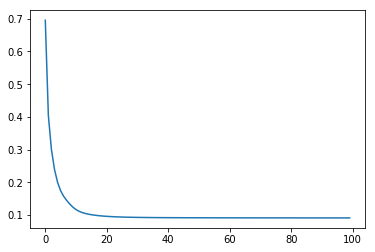

In [107]:
plt.plot(costs)

In [124]:
node_list = [25,18,14,18,25]
NN = NeuralNetwork(X.shape[1] , X.shape[1], node_list, activation = "sigmoid")

### Fitting the model
#### NN.fit(Feature set, output class, epoch = 10, Learning Rate = 0.01, cost_check = False, batch = False, batch_size = -1, savefile=False)
* For best results use NN.fit(Feature set, output class, epoch = 1000, Learning Rate = 0.1, cost_check=True, batch = True, batch_size = 500, savefile=True)

In [125]:
costs, res_list = NN.fit(X, X, 100, 0.01, cost_check=True, batch = True, batch_size = 512)

epoch:  0 iteration:  0
epoch:  0 iteration:  1
epoch:  0 iteration:  2
epoch:  0 iteration:  3
epoch:  0 iteration:  4
epoch:  0 iteration:  5
epoch:  0 iteration:  6
epoch:  0 iteration:  7
epoch:  0 iteration:  8
epoch:  0 iteration:  9
epoch:  0 iteration:  10
epoch:  0 iteration:  11
epoch:  0 iteration:  12
epoch:  0 iteration:  13
epoch:  0 iteration:  14
epoch:  0 iteration:  15
epoch:  0 iteration:  16
epoch:  0 iteration:  17
epoch:  0 iteration:  18
epoch:  0 iteration:  19
epoch:  0 iteration:  20
epoch:  0 iteration:  21
epoch:  0 iteration:  22
epoch:  0 iteration:  23
epoch:  0 iteration:  24
epoch:  0 iteration:  25
epoch:  0 iteration:  26
epoch:  0 iteration:  27
epoch:  0 iteration:  28
epoch:  0 iteration:  29
epoch:  0 iteration:  30
epoch:  0 iteration:  31
epoch:  0 iteration:  32
epoch:  0 iteration:  33
epoch:  0 iteration:  34
epoch:  0 iteration:  35
epoch:  0 iteration:  36
epoch:  0 iteration:  37
epoch:  0 iteration:  38
epoch:  0 iteration:  39
epoch:  0 

epoch:  7 iteration:  17
epoch:  7 iteration:  18
epoch:  7 iteration:  19
epoch:  7 iteration:  20
epoch:  7 iteration:  21
epoch:  7 iteration:  22
epoch:  7 iteration:  23
epoch:  7 iteration:  24
epoch:  7 iteration:  25
epoch:  7 iteration:  26
epoch:  7 iteration:  27
epoch:  7 iteration:  28
epoch:  7 iteration:  29
epoch:  7 iteration:  30
epoch:  7 iteration:  31
epoch:  7 iteration:  32
epoch:  7 iteration:  33
epoch:  7 iteration:  34
epoch:  7 iteration:  35
epoch:  7 iteration:  36
epoch:  7 iteration:  37
epoch:  7 iteration:  38
epoch:  7 iteration:  39
epoch:  7 iteration:  40
epoch:  7 iteration:  41
epoch:  7 iteration:  42
epoch:  7 iteration:  43
epoch:  7 iteration:  44
epoch:  7 iteration:  45
epoch:  7 iteration:  46
epoch:  7 iteration:  47
epoch:  7 iteration:  48
cost[ 7 ]:  1.1279072907338012
epoch:  8 iteration:  0
epoch:  8 iteration:  1
epoch:  8 iteration:  2
epoch:  8 iteration:  3
epoch:  8 iteration:  4
epoch:  8 iteration:  5
epoch:  8 iteration:  6
e

epoch:  15 iteration:  37
epoch:  15 iteration:  38
epoch:  15 iteration:  39
epoch:  15 iteration:  40
epoch:  15 iteration:  41
epoch:  15 iteration:  42
epoch:  15 iteration:  43
epoch:  15 iteration:  44
epoch:  15 iteration:  45
epoch:  15 iteration:  46
epoch:  15 iteration:  47
epoch:  15 iteration:  48
cost[ 15 ]:  1.0493343784469586
epoch:  16 iteration:  0
epoch:  16 iteration:  1
epoch:  16 iteration:  2
epoch:  16 iteration:  3
epoch:  16 iteration:  4
epoch:  16 iteration:  5
epoch:  16 iteration:  6
epoch:  16 iteration:  7
epoch:  16 iteration:  8
epoch:  16 iteration:  9
epoch:  16 iteration:  10
epoch:  16 iteration:  11
epoch:  16 iteration:  12
epoch:  16 iteration:  13
epoch:  16 iteration:  14
epoch:  16 iteration:  15
epoch:  16 iteration:  16
epoch:  16 iteration:  17
epoch:  16 iteration:  18
epoch:  16 iteration:  19
epoch:  16 iteration:  20
epoch:  16 iteration:  21
epoch:  16 iteration:  22
epoch:  16 iteration:  23
epoch:  16 iteration:  24
epoch:  16 itera

epoch:  23 iteration:  37
epoch:  23 iteration:  38
epoch:  23 iteration:  39
epoch:  23 iteration:  40
epoch:  23 iteration:  41
epoch:  23 iteration:  42
epoch:  23 iteration:  43
epoch:  23 iteration:  44
epoch:  23 iteration:  45
epoch:  23 iteration:  46
epoch:  23 iteration:  47
epoch:  23 iteration:  48
cost[ 23 ]:  1.0116210552402045
epoch:  24 iteration:  0
epoch:  24 iteration:  1
epoch:  24 iteration:  2
epoch:  24 iteration:  3
epoch:  24 iteration:  4
epoch:  24 iteration:  5
epoch:  24 iteration:  6
epoch:  24 iteration:  7
epoch:  24 iteration:  8
epoch:  24 iteration:  9
epoch:  24 iteration:  10
epoch:  24 iteration:  11
epoch:  24 iteration:  12
epoch:  24 iteration:  13
epoch:  24 iteration:  14
epoch:  24 iteration:  15
epoch:  24 iteration:  16
epoch:  24 iteration:  17
epoch:  24 iteration:  18
epoch:  24 iteration:  19
epoch:  24 iteration:  20
epoch:  24 iteration:  21
epoch:  24 iteration:  22
epoch:  24 iteration:  23
epoch:  24 iteration:  24
epoch:  24 itera

epoch:  31 iteration:  23
epoch:  31 iteration:  24
epoch:  31 iteration:  25
epoch:  31 iteration:  26
epoch:  31 iteration:  27
epoch:  31 iteration:  28
epoch:  31 iteration:  29
epoch:  31 iteration:  30
epoch:  31 iteration:  31
epoch:  31 iteration:  32
epoch:  31 iteration:  33
epoch:  31 iteration:  34
epoch:  31 iteration:  35
epoch:  31 iteration:  36
epoch:  31 iteration:  37
epoch:  31 iteration:  38
epoch:  31 iteration:  39
epoch:  31 iteration:  40
epoch:  31 iteration:  41
epoch:  31 iteration:  42
epoch:  31 iteration:  43
epoch:  31 iteration:  44
epoch:  31 iteration:  45
epoch:  31 iteration:  46
epoch:  31 iteration:  47
epoch:  31 iteration:  48
cost[ 31 ]:  0.9917061913322075
epoch:  32 iteration:  0
epoch:  32 iteration:  1
epoch:  32 iteration:  2
epoch:  32 iteration:  3
epoch:  32 iteration:  4
epoch:  32 iteration:  5
epoch:  32 iteration:  6
epoch:  32 iteration:  7
epoch:  32 iteration:  8
epoch:  32 iteration:  9
epoch:  32 iteration:  10
epoch:  32 itera

epoch:  39 iteration:  12
epoch:  39 iteration:  13
epoch:  39 iteration:  14
epoch:  39 iteration:  15
epoch:  39 iteration:  16
epoch:  39 iteration:  17
epoch:  39 iteration:  18
epoch:  39 iteration:  19
epoch:  39 iteration:  20
epoch:  39 iteration:  21
epoch:  39 iteration:  22
epoch:  39 iteration:  23
epoch:  39 iteration:  24
epoch:  39 iteration:  25
epoch:  39 iteration:  26
epoch:  39 iteration:  27
epoch:  39 iteration:  28
epoch:  39 iteration:  29
epoch:  39 iteration:  30
epoch:  39 iteration:  31
epoch:  39 iteration:  32
epoch:  39 iteration:  33
epoch:  39 iteration:  34
epoch:  39 iteration:  35
epoch:  39 iteration:  36
epoch:  39 iteration:  37
epoch:  39 iteration:  38
epoch:  39 iteration:  39
epoch:  39 iteration:  40
epoch:  39 iteration:  41
epoch:  39 iteration:  42
epoch:  39 iteration:  43
epoch:  39 iteration:  44
epoch:  39 iteration:  45
epoch:  39 iteration:  46
epoch:  39 iteration:  47
epoch:  39 iteration:  48
cost[ 39 ]:  0.9800799017881029
epoch:

epoch:  47 iteration:  26
epoch:  47 iteration:  27
epoch:  47 iteration:  28
epoch:  47 iteration:  29
epoch:  47 iteration:  30
epoch:  47 iteration:  31
epoch:  47 iteration:  32
epoch:  47 iteration:  33
epoch:  47 iteration:  34
epoch:  47 iteration:  35
epoch:  47 iteration:  36
epoch:  47 iteration:  37
epoch:  47 iteration:  38
epoch:  47 iteration:  39
epoch:  47 iteration:  40
epoch:  47 iteration:  41
epoch:  47 iteration:  42
epoch:  47 iteration:  43
epoch:  47 iteration:  44
epoch:  47 iteration:  45
epoch:  47 iteration:  46
epoch:  47 iteration:  47
epoch:  47 iteration:  48
cost[ 47 ]:  0.9728179488050157
epoch:  48 iteration:  0
epoch:  48 iteration:  1
epoch:  48 iteration:  2
epoch:  48 iteration:  3
epoch:  48 iteration:  4
epoch:  48 iteration:  5
epoch:  48 iteration:  6
epoch:  48 iteration:  7
epoch:  48 iteration:  8
epoch:  48 iteration:  9
epoch:  48 iteration:  10
epoch:  48 iteration:  11
epoch:  48 iteration:  12
epoch:  48 iteration:  13
epoch:  48 itera

epoch:  55 iteration:  30
epoch:  55 iteration:  31
epoch:  55 iteration:  32
epoch:  55 iteration:  33
epoch:  55 iteration:  34
epoch:  55 iteration:  35
epoch:  55 iteration:  36
epoch:  55 iteration:  37
epoch:  55 iteration:  38
epoch:  55 iteration:  39
epoch:  55 iteration:  40
epoch:  55 iteration:  41
epoch:  55 iteration:  42
epoch:  55 iteration:  43
epoch:  55 iteration:  44
epoch:  55 iteration:  45
epoch:  55 iteration:  46
epoch:  55 iteration:  47
epoch:  55 iteration:  48
cost[ 55 ]:  0.968072066070446
epoch:  56 iteration:  0
epoch:  56 iteration:  1
epoch:  56 iteration:  2
epoch:  56 iteration:  3
epoch:  56 iteration:  4
epoch:  56 iteration:  5
epoch:  56 iteration:  6
epoch:  56 iteration:  7
epoch:  56 iteration:  8
epoch:  56 iteration:  9
epoch:  56 iteration:  10
epoch:  56 iteration:  11
epoch:  56 iteration:  12
epoch:  56 iteration:  13
epoch:  56 iteration:  14
epoch:  56 iteration:  15
epoch:  56 iteration:  16
epoch:  56 iteration:  17
epoch:  56 iterat

epoch:  63 iteration:  34
epoch:  63 iteration:  35
epoch:  63 iteration:  36
epoch:  63 iteration:  37
epoch:  63 iteration:  38
epoch:  63 iteration:  39
epoch:  63 iteration:  40
epoch:  63 iteration:  41
epoch:  63 iteration:  42
epoch:  63 iteration:  43
epoch:  63 iteration:  44
epoch:  63 iteration:  45
epoch:  63 iteration:  46
epoch:  63 iteration:  47
epoch:  63 iteration:  48
cost[ 63 ]:  0.9648770747872054
epoch:  64 iteration:  0
epoch:  64 iteration:  1
epoch:  64 iteration:  2
epoch:  64 iteration:  3
epoch:  64 iteration:  4
epoch:  64 iteration:  5
epoch:  64 iteration:  6
epoch:  64 iteration:  7
epoch:  64 iteration:  8
epoch:  64 iteration:  9
epoch:  64 iteration:  10
epoch:  64 iteration:  11
epoch:  64 iteration:  12
epoch:  64 iteration:  13
epoch:  64 iteration:  14
epoch:  64 iteration:  15
epoch:  64 iteration:  16
epoch:  64 iteration:  17
epoch:  64 iteration:  18
epoch:  64 iteration:  19
epoch:  64 iteration:  20
epoch:  64 iteration:  21
epoch:  64 itera

epoch:  71 iteration:  18
epoch:  71 iteration:  19
epoch:  71 iteration:  20
epoch:  71 iteration:  21
epoch:  71 iteration:  22
epoch:  71 iteration:  23
epoch:  71 iteration:  24
epoch:  71 iteration:  25
epoch:  71 iteration:  26
epoch:  71 iteration:  27
epoch:  71 iteration:  28
epoch:  71 iteration:  29
epoch:  71 iteration:  30
epoch:  71 iteration:  31
epoch:  71 iteration:  32
epoch:  71 iteration:  33
epoch:  71 iteration:  34
epoch:  71 iteration:  35
epoch:  71 iteration:  36
epoch:  71 iteration:  37
epoch:  71 iteration:  38
epoch:  71 iteration:  39
epoch:  71 iteration:  40
epoch:  71 iteration:  41
epoch:  71 iteration:  42
epoch:  71 iteration:  43
epoch:  71 iteration:  44
epoch:  71 iteration:  45
epoch:  71 iteration:  46
epoch:  71 iteration:  47
epoch:  71 iteration:  48
cost[ 71 ]:  0.9626951255764863
epoch:  72 iteration:  0
epoch:  72 iteration:  1
epoch:  72 iteration:  2
epoch:  72 iteration:  3
epoch:  72 iteration:  4
epoch:  72 iteration:  5
epoch:  72 i

epoch:  79 iteration:  33
epoch:  79 iteration:  34
epoch:  79 iteration:  35
epoch:  79 iteration:  36
epoch:  79 iteration:  37
epoch:  79 iteration:  38
epoch:  79 iteration:  39
epoch:  79 iteration:  40
epoch:  79 iteration:  41
epoch:  79 iteration:  42
epoch:  79 iteration:  43
epoch:  79 iteration:  44
epoch:  79 iteration:  45
epoch:  79 iteration:  46
epoch:  79 iteration:  47
epoch:  79 iteration:  48
cost[ 79 ]:  0.9611951962470853
epoch:  80 iteration:  0
epoch:  80 iteration:  1
epoch:  80 iteration:  2
epoch:  80 iteration:  3
epoch:  80 iteration:  4
epoch:  80 iteration:  5
epoch:  80 iteration:  6
epoch:  80 iteration:  7
epoch:  80 iteration:  8
epoch:  80 iteration:  9
epoch:  80 iteration:  10
epoch:  80 iteration:  11
epoch:  80 iteration:  12
epoch:  80 iteration:  13
epoch:  80 iteration:  14
epoch:  80 iteration:  15
epoch:  80 iteration:  16
epoch:  80 iteration:  17
epoch:  80 iteration:  18
epoch:  80 iteration:  19
epoch:  80 iteration:  20
epoch:  80 itera

epoch:  87 iteration:  21
epoch:  87 iteration:  22
epoch:  87 iteration:  23
epoch:  87 iteration:  24
epoch:  87 iteration:  25
epoch:  87 iteration:  26
epoch:  87 iteration:  27
epoch:  87 iteration:  28
epoch:  87 iteration:  29
epoch:  87 iteration:  30
epoch:  87 iteration:  31
epoch:  87 iteration:  32
epoch:  87 iteration:  33
epoch:  87 iteration:  34
epoch:  87 iteration:  35
epoch:  87 iteration:  36
epoch:  87 iteration:  37
epoch:  87 iteration:  38
epoch:  87 iteration:  39
epoch:  87 iteration:  40
epoch:  87 iteration:  41
epoch:  87 iteration:  42
epoch:  87 iteration:  43
epoch:  87 iteration:  44
epoch:  87 iteration:  45
epoch:  87 iteration:  46
epoch:  87 iteration:  47
epoch:  87 iteration:  48
cost[ 87 ]:  0.960169065658765
epoch:  88 iteration:  0
epoch:  88 iteration:  1
epoch:  88 iteration:  2
epoch:  88 iteration:  3
epoch:  88 iteration:  4
epoch:  88 iteration:  5
epoch:  88 iteration:  6
epoch:  88 iteration:  7
epoch:  88 iteration:  8
epoch:  88 itera

epoch:  95 iteration:  22
epoch:  95 iteration:  23
epoch:  95 iteration:  24
epoch:  95 iteration:  25
epoch:  95 iteration:  26
epoch:  95 iteration:  27
epoch:  95 iteration:  28
epoch:  95 iteration:  29
epoch:  95 iteration:  30
epoch:  95 iteration:  31
epoch:  95 iteration:  32
epoch:  95 iteration:  33
epoch:  95 iteration:  34
epoch:  95 iteration:  35
epoch:  95 iteration:  36
epoch:  95 iteration:  37
epoch:  95 iteration:  38
epoch:  95 iteration:  39
epoch:  95 iteration:  40
epoch:  95 iteration:  41
epoch:  95 iteration:  42
epoch:  95 iteration:  43
epoch:  95 iteration:  44
epoch:  95 iteration:  45
epoch:  95 iteration:  46
epoch:  95 iteration:  47
epoch:  95 iteration:  48
cost[ 95 ]:  0.9594850082896341
epoch:  96 iteration:  0
epoch:  96 iteration:  1
epoch:  96 iteration:  2
epoch:  96 iteration:  3
epoch:  96 iteration:  4
epoch:  96 iteration:  5
epoch:  96 iteration:  6
epoch:  96 iteration:  7
epoch:  96 iteration:  8
epoch:  96 iteration:  9
epoch:  96 itera

In [110]:
save_to_csv(res_list, "q-1-1_b_sigmoid")

### Cost vs epochs

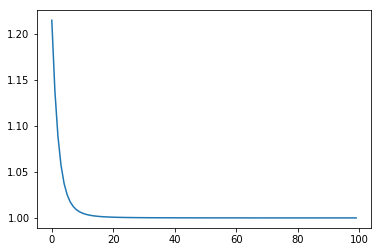

In [111]:
plt.plot(costs)

In [120]:
node_list = [14]
NN = NeuralNetwork(X.shape[1] , X.shape[1], node_list, activation = "ReLU")

### Fitting the model
#### NN.fit(Feature set, output class, epoch = 10, Learning Rate = 0.01, cost_check = False, batch = False, batch_size = -1, savefile=False)
* For best results use NN.fit(Feature set, output class, epoch = 1000, Learning Rate = 0.1, cost_check=True, batch = True, batch_size = 500, savefile=True)

In [121]:
costs, res_list = NN.fit(X, X, 100, 0.01, cost_check=True, batch = True, batch_size = 512)

epoch:  0 iteration:  0
epoch:  0 iteration:  1
epoch:  0 iteration:  2
epoch:  0 iteration:  3
epoch:  0 iteration:  4
epoch:  0 iteration:  5
epoch:  0 iteration:  6
epoch:  0 iteration:  7
epoch:  0 iteration:  8
epoch:  0 iteration:  9
epoch:  0 iteration:  10
epoch:  0 iteration:  11
epoch:  0 iteration:  12
epoch:  0 iteration:  13
epoch:  0 iteration:  14
epoch:  0 iteration:  15
epoch:  0 iteration:  16
epoch:  0 iteration:  17
epoch:  0 iteration:  18
epoch:  0 iteration:  19
epoch:  0 iteration:  20
epoch:  0 iteration:  21
epoch:  0 iteration:  22
epoch:  0 iteration:  23
epoch:  0 iteration:  24
epoch:  0 iteration:  25
epoch:  0 iteration:  26
epoch:  0 iteration:  27
epoch:  0 iteration:  28
epoch:  0 iteration:  29
epoch:  0 iteration:  30
epoch:  0 iteration:  31
epoch:  0 iteration:  32
epoch:  0 iteration:  33
epoch:  0 iteration:  34
epoch:  0 iteration:  35
epoch:  0 iteration:  36
epoch:  0 iteration:  37
epoch:  0 iteration:  38
epoch:  0 iteration:  39
epoch:  0 

epoch:  7 iteration:  24
epoch:  7 iteration:  25
epoch:  7 iteration:  26
epoch:  7 iteration:  27
epoch:  7 iteration:  28
epoch:  7 iteration:  29
epoch:  7 iteration:  30
epoch:  7 iteration:  31
epoch:  7 iteration:  32
epoch:  7 iteration:  33
epoch:  7 iteration:  34
epoch:  7 iteration:  35
epoch:  7 iteration:  36
epoch:  7 iteration:  37
epoch:  7 iteration:  38
epoch:  7 iteration:  39
epoch:  7 iteration:  40
epoch:  7 iteration:  41
epoch:  7 iteration:  42
epoch:  7 iteration:  43
epoch:  7 iteration:  44
epoch:  7 iteration:  45
epoch:  7 iteration:  46
epoch:  7 iteration:  47
epoch:  7 iteration:  48
cost[ 7 ]:  0.5453026747069971
epoch:  8 iteration:  0
epoch:  8 iteration:  1
epoch:  8 iteration:  2
epoch:  8 iteration:  3
epoch:  8 iteration:  4
epoch:  8 iteration:  5
epoch:  8 iteration:  6
epoch:  8 iteration:  7
epoch:  8 iteration:  8
epoch:  8 iteration:  9
epoch:  8 iteration:  10
epoch:  8 iteration:  11
epoch:  8 iteration:  12
epoch:  8 iteration:  13
epoc

epoch:  15 iteration:  0
epoch:  15 iteration:  1
epoch:  15 iteration:  2
epoch:  15 iteration:  3
epoch:  15 iteration:  4
epoch:  15 iteration:  5
epoch:  15 iteration:  6
epoch:  15 iteration:  7
epoch:  15 iteration:  8
epoch:  15 iteration:  9
epoch:  15 iteration:  10
epoch:  15 iteration:  11
epoch:  15 iteration:  12
epoch:  15 iteration:  13
epoch:  15 iteration:  14
epoch:  15 iteration:  15
epoch:  15 iteration:  16
epoch:  15 iteration:  17
epoch:  15 iteration:  18
epoch:  15 iteration:  19
epoch:  15 iteration:  20
epoch:  15 iteration:  21
epoch:  15 iteration:  22
epoch:  15 iteration:  23
epoch:  15 iteration:  24
epoch:  15 iteration:  25
epoch:  15 iteration:  26
epoch:  15 iteration:  27
epoch:  15 iteration:  28
epoch:  15 iteration:  29
epoch:  15 iteration:  30
epoch:  15 iteration:  31
epoch:  15 iteration:  32
epoch:  15 iteration:  33
epoch:  15 iteration:  34
epoch:  15 iteration:  35
epoch:  15 iteration:  36
epoch:  15 iteration:  37
epoch:  15 iteration: 

epoch:  22 iteration:  33
epoch:  22 iteration:  34
epoch:  22 iteration:  35
epoch:  22 iteration:  36
epoch:  22 iteration:  37
epoch:  22 iteration:  38
epoch:  22 iteration:  39
epoch:  22 iteration:  40
epoch:  22 iteration:  41
epoch:  22 iteration:  42
epoch:  22 iteration:  43
epoch:  22 iteration:  44
epoch:  22 iteration:  45
epoch:  22 iteration:  46
epoch:  22 iteration:  47
epoch:  22 iteration:  48
cost[ 22 ]:  0.4271292275484329
epoch:  23 iteration:  0
epoch:  23 iteration:  1
epoch:  23 iteration:  2
epoch:  23 iteration:  3
epoch:  23 iteration:  4
epoch:  23 iteration:  5
epoch:  23 iteration:  6
epoch:  23 iteration:  7
epoch:  23 iteration:  8
epoch:  23 iteration:  9
epoch:  23 iteration:  10
epoch:  23 iteration:  11
epoch:  23 iteration:  12
epoch:  23 iteration:  13
epoch:  23 iteration:  14
epoch:  23 iteration:  15
epoch:  23 iteration:  16
epoch:  23 iteration:  17
epoch:  23 iteration:  18
epoch:  23 iteration:  19
epoch:  23 iteration:  20
epoch:  23 itera

epoch:  29 iteration:  39
epoch:  29 iteration:  40
epoch:  29 iteration:  41
epoch:  29 iteration:  42
epoch:  29 iteration:  43
epoch:  29 iteration:  44
epoch:  29 iteration:  45
epoch:  29 iteration:  46
epoch:  29 iteration:  47
epoch:  29 iteration:  48
cost[ 29 ]:  0.4138738227375706
epoch:  30 iteration:  0
epoch:  30 iteration:  1
epoch:  30 iteration:  2
epoch:  30 iteration:  3
epoch:  30 iteration:  4
epoch:  30 iteration:  5
epoch:  30 iteration:  6
epoch:  30 iteration:  7
epoch:  30 iteration:  8
epoch:  30 iteration:  9
epoch:  30 iteration:  10
epoch:  30 iteration:  11
epoch:  30 iteration:  12
epoch:  30 iteration:  13
epoch:  30 iteration:  14
epoch:  30 iteration:  15
epoch:  30 iteration:  16
epoch:  30 iteration:  17
epoch:  30 iteration:  18
epoch:  30 iteration:  19
epoch:  30 iteration:  20
epoch:  30 iteration:  21
epoch:  30 iteration:  22
epoch:  30 iteration:  23
epoch:  30 iteration:  24
epoch:  30 iteration:  25
epoch:  30 iteration:  26
epoch:  30 itera

cost[ 36 ]:  0.39092047804877283
epoch:  37 iteration:  0
epoch:  37 iteration:  1
epoch:  37 iteration:  2
epoch:  37 iteration:  3
epoch:  37 iteration:  4
epoch:  37 iteration:  5
epoch:  37 iteration:  6
epoch:  37 iteration:  7
epoch:  37 iteration:  8
epoch:  37 iteration:  9
epoch:  37 iteration:  10
epoch:  37 iteration:  11
epoch:  37 iteration:  12
epoch:  37 iteration:  13
epoch:  37 iteration:  14
epoch:  37 iteration:  15
epoch:  37 iteration:  16
epoch:  37 iteration:  17
epoch:  37 iteration:  18
epoch:  37 iteration:  19
epoch:  37 iteration:  20
epoch:  37 iteration:  21
epoch:  37 iteration:  22
epoch:  37 iteration:  23
epoch:  37 iteration:  24
epoch:  37 iteration:  25
epoch:  37 iteration:  26
epoch:  37 iteration:  27
epoch:  37 iteration:  28
epoch:  37 iteration:  29
epoch:  37 iteration:  30
epoch:  37 iteration:  31
epoch:  37 iteration:  32
epoch:  37 iteration:  33
epoch:  37 iteration:  34
epoch:  37 iteration:  35
epoch:  37 iteration:  36
epoch:  37 iter

epoch:  44 iteration:  30
epoch:  44 iteration:  31
epoch:  44 iteration:  32
epoch:  44 iteration:  33
epoch:  44 iteration:  34
epoch:  44 iteration:  35
epoch:  44 iteration:  36
epoch:  44 iteration:  37
epoch:  44 iteration:  38
epoch:  44 iteration:  39
epoch:  44 iteration:  40
epoch:  44 iteration:  41
epoch:  44 iteration:  42
epoch:  44 iteration:  43
epoch:  44 iteration:  44
epoch:  44 iteration:  45
epoch:  44 iteration:  46
epoch:  44 iteration:  47
epoch:  44 iteration:  48
cost[ 44 ]:  0.3897350447802558
epoch:  45 iteration:  0
epoch:  45 iteration:  1
epoch:  45 iteration:  2
epoch:  45 iteration:  3
epoch:  45 iteration:  4
epoch:  45 iteration:  5
epoch:  45 iteration:  6
epoch:  45 iteration:  7
epoch:  45 iteration:  8
epoch:  45 iteration:  9
epoch:  45 iteration:  10
epoch:  45 iteration:  11
epoch:  45 iteration:  12
epoch:  45 iteration:  13
epoch:  45 iteration:  14
epoch:  45 iteration:  15
epoch:  45 iteration:  16
epoch:  45 iteration:  17
epoch:  45 itera

epoch:  52 iteration:  0
epoch:  52 iteration:  1
epoch:  52 iteration:  2
epoch:  52 iteration:  3
epoch:  52 iteration:  4
epoch:  52 iteration:  5
epoch:  52 iteration:  6
epoch:  52 iteration:  7
epoch:  52 iteration:  8
epoch:  52 iteration:  9
epoch:  52 iteration:  10
epoch:  52 iteration:  11
epoch:  52 iteration:  12
epoch:  52 iteration:  13
epoch:  52 iteration:  14
epoch:  52 iteration:  15
epoch:  52 iteration:  16
epoch:  52 iteration:  17
epoch:  52 iteration:  18
epoch:  52 iteration:  19
epoch:  52 iteration:  20
epoch:  52 iteration:  21
epoch:  52 iteration:  22
epoch:  52 iteration:  23
epoch:  52 iteration:  24
epoch:  52 iteration:  25
epoch:  52 iteration:  26
epoch:  52 iteration:  27
epoch:  52 iteration:  28
epoch:  52 iteration:  29
epoch:  52 iteration:  30
epoch:  52 iteration:  31
epoch:  52 iteration:  32
epoch:  52 iteration:  33
epoch:  52 iteration:  34
epoch:  52 iteration:  35
epoch:  52 iteration:  36
epoch:  52 iteration:  37
epoch:  52 iteration: 

epoch:  59 iteration:  44
epoch:  59 iteration:  45
epoch:  59 iteration:  46
epoch:  59 iteration:  47
epoch:  59 iteration:  48
cost[ 59 ]:  0.38596260932415577
epoch:  60 iteration:  0
epoch:  60 iteration:  1
epoch:  60 iteration:  2
epoch:  60 iteration:  3
epoch:  60 iteration:  4
epoch:  60 iteration:  5
epoch:  60 iteration:  6
epoch:  60 iteration:  7
epoch:  60 iteration:  8
epoch:  60 iteration:  9
epoch:  60 iteration:  10
epoch:  60 iteration:  11
epoch:  60 iteration:  12
epoch:  60 iteration:  13
epoch:  60 iteration:  14
epoch:  60 iteration:  15
epoch:  60 iteration:  16
epoch:  60 iteration:  17
epoch:  60 iteration:  18
epoch:  60 iteration:  19
epoch:  60 iteration:  20
epoch:  60 iteration:  21
epoch:  60 iteration:  22
epoch:  60 iteration:  23
epoch:  60 iteration:  24
epoch:  60 iteration:  25
epoch:  60 iteration:  26
epoch:  60 iteration:  27
epoch:  60 iteration:  28
epoch:  60 iteration:  29
epoch:  60 iteration:  30
epoch:  60 iteration:  31
epoch:  60 iter

epoch:  67 iteration:  17
epoch:  67 iteration:  18
epoch:  67 iteration:  19
epoch:  67 iteration:  20
epoch:  67 iteration:  21
epoch:  67 iteration:  22
epoch:  67 iteration:  23
epoch:  67 iteration:  24
epoch:  67 iteration:  25
epoch:  67 iteration:  26
epoch:  67 iteration:  27
epoch:  67 iteration:  28
epoch:  67 iteration:  29
epoch:  67 iteration:  30
epoch:  67 iteration:  31
epoch:  67 iteration:  32
epoch:  67 iteration:  33
epoch:  67 iteration:  34
epoch:  67 iteration:  35
epoch:  67 iteration:  36
epoch:  67 iteration:  37
epoch:  67 iteration:  38
epoch:  67 iteration:  39
epoch:  67 iteration:  40
epoch:  67 iteration:  41
epoch:  67 iteration:  42
epoch:  67 iteration:  43
epoch:  67 iteration:  44
epoch:  67 iteration:  45
epoch:  67 iteration:  46
epoch:  67 iteration:  47
epoch:  67 iteration:  48
cost[ 67 ]:  0.3575730202208296
epoch:  68 iteration:  0
epoch:  68 iteration:  1
epoch:  68 iteration:  2
epoch:  68 iteration:  3
epoch:  68 iteration:  4
epoch:  68 

epoch:  74 iteration:  29
epoch:  74 iteration:  30
epoch:  74 iteration:  31
epoch:  74 iteration:  32
epoch:  74 iteration:  33
epoch:  74 iteration:  34
epoch:  74 iteration:  35
epoch:  74 iteration:  36
epoch:  74 iteration:  37
epoch:  74 iteration:  38
epoch:  74 iteration:  39
epoch:  74 iteration:  40
epoch:  74 iteration:  41
epoch:  74 iteration:  42
epoch:  74 iteration:  43
epoch:  74 iteration:  44
epoch:  74 iteration:  45
epoch:  74 iteration:  46
epoch:  74 iteration:  47
epoch:  74 iteration:  48
cost[ 74 ]:  0.35426176707150014
epoch:  75 iteration:  0
epoch:  75 iteration:  1
epoch:  75 iteration:  2
epoch:  75 iteration:  3
epoch:  75 iteration:  4
epoch:  75 iteration:  5
epoch:  75 iteration:  6
epoch:  75 iteration:  7
epoch:  75 iteration:  8
epoch:  75 iteration:  9
epoch:  75 iteration:  10
epoch:  75 iteration:  11
epoch:  75 iteration:  12
epoch:  75 iteration:  13
epoch:  75 iteration:  14
epoch:  75 iteration:  15
epoch:  75 iteration:  16
epoch:  75 iter

epoch:  82 iteration:  18
epoch:  82 iteration:  19
epoch:  82 iteration:  20
epoch:  82 iteration:  21
epoch:  82 iteration:  22
epoch:  82 iteration:  23
epoch:  82 iteration:  24
epoch:  82 iteration:  25
epoch:  82 iteration:  26
epoch:  82 iteration:  27
epoch:  82 iteration:  28
epoch:  82 iteration:  29
epoch:  82 iteration:  30
epoch:  82 iteration:  31
epoch:  82 iteration:  32
epoch:  82 iteration:  33
epoch:  82 iteration:  34
epoch:  82 iteration:  35
epoch:  82 iteration:  36
epoch:  82 iteration:  37
epoch:  82 iteration:  38
epoch:  82 iteration:  39
epoch:  82 iteration:  40
epoch:  82 iteration:  41
epoch:  82 iteration:  42
epoch:  82 iteration:  43
epoch:  82 iteration:  44
epoch:  82 iteration:  45
epoch:  82 iteration:  46
epoch:  82 iteration:  47
epoch:  82 iteration:  48
cost[ 82 ]:  0.3533973218253896
epoch:  83 iteration:  0
epoch:  83 iteration:  1
epoch:  83 iteration:  2
epoch:  83 iteration:  3
epoch:  83 iteration:  4
epoch:  83 iteration:  5
epoch:  83 i

epoch:  88 iteration:  34
epoch:  88 iteration:  35
epoch:  88 iteration:  36
epoch:  88 iteration:  37
epoch:  88 iteration:  38
epoch:  88 iteration:  39
epoch:  88 iteration:  40
epoch:  88 iteration:  41
epoch:  88 iteration:  42
epoch:  88 iteration:  43
epoch:  88 iteration:  44
epoch:  88 iteration:  45
epoch:  88 iteration:  46
epoch:  88 iteration:  47
epoch:  88 iteration:  48
cost[ 88 ]:  0.35258573548931177
epoch:  89 iteration:  0
epoch:  89 iteration:  1
epoch:  89 iteration:  2
epoch:  89 iteration:  3
epoch:  89 iteration:  4
epoch:  89 iteration:  5
epoch:  89 iteration:  6
epoch:  89 iteration:  7
epoch:  89 iteration:  8
epoch:  89 iteration:  9
epoch:  89 iteration:  10
epoch:  89 iteration:  11
epoch:  89 iteration:  12
epoch:  89 iteration:  13
epoch:  89 iteration:  14
epoch:  89 iteration:  15
epoch:  89 iteration:  16
epoch:  89 iteration:  17
epoch:  89 iteration:  18
epoch:  89 iteration:  19
epoch:  89 iteration:  20
epoch:  89 iteration:  21
epoch:  89 iter

epoch:  96 iteration:  24
epoch:  96 iteration:  25
epoch:  96 iteration:  26
epoch:  96 iteration:  27
epoch:  96 iteration:  28
epoch:  96 iteration:  29
epoch:  96 iteration:  30
epoch:  96 iteration:  31
epoch:  96 iteration:  32
epoch:  96 iteration:  33
epoch:  96 iteration:  34
epoch:  96 iteration:  35
epoch:  96 iteration:  36
epoch:  96 iteration:  37
epoch:  96 iteration:  38
epoch:  96 iteration:  39
epoch:  96 iteration:  40
epoch:  96 iteration:  41
epoch:  96 iteration:  42
epoch:  96 iteration:  43
epoch:  96 iteration:  44
epoch:  96 iteration:  45
epoch:  96 iteration:  46
epoch:  96 iteration:  47
epoch:  96 iteration:  48
cost[ 96 ]:  0.351181154174418
epoch:  97 iteration:  0
epoch:  97 iteration:  1
epoch:  97 iteration:  2
epoch:  97 iteration:  3
epoch:  97 iteration:  4
epoch:  97 iteration:  5
epoch:  97 iteration:  6
epoch:  97 iteration:  7
epoch:  97 iteration:  8
epoch:  97 iteration:  9
epoch:  97 iteration:  10
epoch:  97 iteration:  11
epoch:  97 iterat

In [122]:
save_to_csv(res_list, "q-1-1_b_ReLU")

### Cost vs epochs

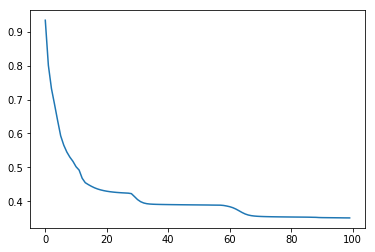

In [123]:
plt.plot(costs)

In [116]:
node_list = [25,18,14,18,25]
NN = NeuralNetwork(X.shape[1] , X.shape[1], node_list, activation = "tanh")

### Fitting the model
#### NN.fit(Feature set, output class, epoch = 10, Learning Rate = 0.01, cost_check = False, batch = False, batch_size = -1, savefile=False)
* For best results use NN.fit(Feature set, output class, epoch = 1000, Learning Rate = 0.1, cost_check=True, batch = True, batch_size = 500, savefile=True)

In [117]:
costs, res_list = NN.fit(X, X, 100, 0.01, cost_check=True, batch = True, batch_size = 512)

epoch:  0 iteration:  0
epoch:  0 iteration:  1
epoch:  0 iteration:  2
epoch:  0 iteration:  3
epoch:  0 iteration:  4
epoch:  0 iteration:  5
epoch:  0 iteration:  6
epoch:  0 iteration:  7
epoch:  0 iteration:  8
epoch:  0 iteration:  9
epoch:  0 iteration:  10
epoch:  0 iteration:  11
epoch:  0 iteration:  12
epoch:  0 iteration:  13
epoch:  0 iteration:  14
epoch:  0 iteration:  15
epoch:  0 iteration:  16
epoch:  0 iteration:  17
epoch:  0 iteration:  18
epoch:  0 iteration:  19
epoch:  0 iteration:  20
epoch:  0 iteration:  21
epoch:  0 iteration:  22
epoch:  0 iteration:  23
epoch:  0 iteration:  24
epoch:  0 iteration:  25
epoch:  0 iteration:  26
epoch:  0 iteration:  27
epoch:  0 iteration:  28
epoch:  0 iteration:  29
epoch:  0 iteration:  30
epoch:  0 iteration:  31
epoch:  0 iteration:  32
epoch:  0 iteration:  33
epoch:  0 iteration:  34
epoch:  0 iteration:  35
epoch:  0 iteration:  36
epoch:  0 iteration:  37
epoch:  0 iteration:  38
epoch:  0 iteration:  39
epoch:  0 

epoch:  7 iteration:  8
epoch:  7 iteration:  9
epoch:  7 iteration:  10
epoch:  7 iteration:  11
epoch:  7 iteration:  12
epoch:  7 iteration:  13
epoch:  7 iteration:  14
epoch:  7 iteration:  15
epoch:  7 iteration:  16
epoch:  7 iteration:  17
epoch:  7 iteration:  18
epoch:  7 iteration:  19
epoch:  7 iteration:  20
epoch:  7 iteration:  21
epoch:  7 iteration:  22
epoch:  7 iteration:  23
epoch:  7 iteration:  24
epoch:  7 iteration:  25
epoch:  7 iteration:  26
epoch:  7 iteration:  27
epoch:  7 iteration:  28
epoch:  7 iteration:  29
epoch:  7 iteration:  30
epoch:  7 iteration:  31
epoch:  7 iteration:  32
epoch:  7 iteration:  33
epoch:  7 iteration:  34
epoch:  7 iteration:  35
epoch:  7 iteration:  36
epoch:  7 iteration:  37
epoch:  7 iteration:  38
epoch:  7 iteration:  39
epoch:  7 iteration:  40
epoch:  7 iteration:  41
epoch:  7 iteration:  42
epoch:  7 iteration:  43
epoch:  7 iteration:  44
epoch:  7 iteration:  45
epoch:  7 iteration:  46
epoch:  7 iteration:  47
ep

epoch:  14 iteration:  23
epoch:  14 iteration:  24
epoch:  14 iteration:  25
epoch:  14 iteration:  26
epoch:  14 iteration:  27
epoch:  14 iteration:  28
epoch:  14 iteration:  29
epoch:  14 iteration:  30
epoch:  14 iteration:  31
epoch:  14 iteration:  32
epoch:  14 iteration:  33
epoch:  14 iteration:  34
epoch:  14 iteration:  35
epoch:  14 iteration:  36
epoch:  14 iteration:  37
epoch:  14 iteration:  38
epoch:  14 iteration:  39
epoch:  14 iteration:  40
epoch:  14 iteration:  41
epoch:  14 iteration:  42
epoch:  14 iteration:  43
epoch:  14 iteration:  44
epoch:  14 iteration:  45
epoch:  14 iteration:  46
epoch:  14 iteration:  47
epoch:  14 iteration:  48
cost[ 14 ]:  0.6514577273803523
epoch:  15 iteration:  0
epoch:  15 iteration:  1
epoch:  15 iteration:  2
epoch:  15 iteration:  3
epoch:  15 iteration:  4
epoch:  15 iteration:  5
epoch:  15 iteration:  6
epoch:  15 iteration:  7
epoch:  15 iteration:  8
epoch:  15 iteration:  9
epoch:  15 iteration:  10
epoch:  15 itera

epoch:  21 iteration:  31
epoch:  21 iteration:  32
epoch:  21 iteration:  33
epoch:  21 iteration:  34
epoch:  21 iteration:  35
epoch:  21 iteration:  36
epoch:  21 iteration:  37
epoch:  21 iteration:  38
epoch:  21 iteration:  39
epoch:  21 iteration:  40
epoch:  21 iteration:  41
epoch:  21 iteration:  42
epoch:  21 iteration:  43
epoch:  21 iteration:  44
epoch:  21 iteration:  45
epoch:  21 iteration:  46
epoch:  21 iteration:  47
epoch:  21 iteration:  48
cost[ 21 ]:  0.6138561350687589
epoch:  22 iteration:  0
epoch:  22 iteration:  1
epoch:  22 iteration:  2
epoch:  22 iteration:  3
epoch:  22 iteration:  4
epoch:  22 iteration:  5
epoch:  22 iteration:  6
epoch:  22 iteration:  7
epoch:  22 iteration:  8
epoch:  22 iteration:  9
epoch:  22 iteration:  10
epoch:  22 iteration:  11
epoch:  22 iteration:  12
epoch:  22 iteration:  13
epoch:  22 iteration:  14
epoch:  22 iteration:  15
epoch:  22 iteration:  16
epoch:  22 iteration:  17
epoch:  22 iteration:  18
epoch:  22 itera

epoch:  28 iteration:  18
epoch:  28 iteration:  19
epoch:  28 iteration:  20
epoch:  28 iteration:  21
epoch:  28 iteration:  22
epoch:  28 iteration:  23
epoch:  28 iteration:  24
epoch:  28 iteration:  25
epoch:  28 iteration:  26
epoch:  28 iteration:  27
epoch:  28 iteration:  28
epoch:  28 iteration:  29
epoch:  28 iteration:  30
epoch:  28 iteration:  31
epoch:  28 iteration:  32
epoch:  28 iteration:  33
epoch:  28 iteration:  34
epoch:  28 iteration:  35
epoch:  28 iteration:  36
epoch:  28 iteration:  37
epoch:  28 iteration:  38
epoch:  28 iteration:  39
epoch:  28 iteration:  40
epoch:  28 iteration:  41
epoch:  28 iteration:  42
epoch:  28 iteration:  43
epoch:  28 iteration:  44
epoch:  28 iteration:  45
epoch:  28 iteration:  46
epoch:  28 iteration:  47
epoch:  28 iteration:  48
cost[ 28 ]:  0.578553716430999
epoch:  29 iteration:  0
epoch:  29 iteration:  1
epoch:  29 iteration:  2
epoch:  29 iteration:  3
epoch:  29 iteration:  4
epoch:  29 iteration:  5
epoch:  29 it

epoch:  35 iteration:  36
epoch:  35 iteration:  37
epoch:  35 iteration:  38
epoch:  35 iteration:  39
epoch:  35 iteration:  40
epoch:  35 iteration:  41
epoch:  35 iteration:  42
epoch:  35 iteration:  43
epoch:  35 iteration:  44
epoch:  35 iteration:  45
epoch:  35 iteration:  46
epoch:  35 iteration:  47
epoch:  35 iteration:  48
cost[ 35 ]:  0.5560296223348675
epoch:  36 iteration:  0
epoch:  36 iteration:  1
epoch:  36 iteration:  2
epoch:  36 iteration:  3
epoch:  36 iteration:  4
epoch:  36 iteration:  5
epoch:  36 iteration:  6
epoch:  36 iteration:  7
epoch:  36 iteration:  8
epoch:  36 iteration:  9
epoch:  36 iteration:  10
epoch:  36 iteration:  11
epoch:  36 iteration:  12
epoch:  36 iteration:  13
epoch:  36 iteration:  14
epoch:  36 iteration:  15
epoch:  36 iteration:  16
epoch:  36 iteration:  17
epoch:  36 iteration:  18
epoch:  36 iteration:  19
epoch:  36 iteration:  20
epoch:  36 iteration:  21
epoch:  36 iteration:  22
epoch:  36 iteration:  23
epoch:  36 itera

epoch:  42 iteration:  14
epoch:  42 iteration:  15
epoch:  42 iteration:  16
epoch:  42 iteration:  17
epoch:  42 iteration:  18
epoch:  42 iteration:  19
epoch:  42 iteration:  20
epoch:  42 iteration:  21
epoch:  42 iteration:  22
epoch:  42 iteration:  23
epoch:  42 iteration:  24
epoch:  42 iteration:  25
epoch:  42 iteration:  26
epoch:  42 iteration:  27
epoch:  42 iteration:  28
epoch:  42 iteration:  29
epoch:  42 iteration:  30
epoch:  42 iteration:  31
epoch:  42 iteration:  32
epoch:  42 iteration:  33
epoch:  42 iteration:  34
epoch:  42 iteration:  35
epoch:  42 iteration:  36
epoch:  42 iteration:  37
epoch:  42 iteration:  38
epoch:  42 iteration:  39
epoch:  42 iteration:  40
epoch:  42 iteration:  41
epoch:  42 iteration:  42
epoch:  42 iteration:  43
epoch:  42 iteration:  44
epoch:  42 iteration:  45
epoch:  42 iteration:  46
epoch:  42 iteration:  47
epoch:  42 iteration:  48
cost[ 42 ]:  0.5442526082086452
epoch:  43 iteration:  0
epoch:  43 iteration:  1
epoch:  

epoch:  49 iteration:  28
epoch:  49 iteration:  29
epoch:  49 iteration:  30
epoch:  49 iteration:  31
epoch:  49 iteration:  32
epoch:  49 iteration:  33
epoch:  49 iteration:  34
epoch:  49 iteration:  35
epoch:  49 iteration:  36
epoch:  49 iteration:  37
epoch:  49 iteration:  38
epoch:  49 iteration:  39
epoch:  49 iteration:  40
epoch:  49 iteration:  41
epoch:  49 iteration:  42
epoch:  49 iteration:  43
epoch:  49 iteration:  44
epoch:  49 iteration:  45
epoch:  49 iteration:  46
epoch:  49 iteration:  47
epoch:  49 iteration:  48
cost[ 49 ]:  0.537067058583705
epoch:  50 iteration:  0
epoch:  50 iteration:  1
epoch:  50 iteration:  2
epoch:  50 iteration:  3
epoch:  50 iteration:  4
epoch:  50 iteration:  5
epoch:  50 iteration:  6
epoch:  50 iteration:  7
epoch:  50 iteration:  8
epoch:  50 iteration:  9
epoch:  50 iteration:  10
epoch:  50 iteration:  11
epoch:  50 iteration:  12
epoch:  50 iteration:  13
epoch:  50 iteration:  14
epoch:  50 iteration:  15
epoch:  50 iterat

epoch:  56 iteration:  24
epoch:  56 iteration:  25
epoch:  56 iteration:  26
epoch:  56 iteration:  27
epoch:  56 iteration:  28
epoch:  56 iteration:  29
epoch:  56 iteration:  30
epoch:  56 iteration:  31
epoch:  56 iteration:  32
epoch:  56 iteration:  33
epoch:  56 iteration:  34
epoch:  56 iteration:  35
epoch:  56 iteration:  36
epoch:  56 iteration:  37
epoch:  56 iteration:  38
epoch:  56 iteration:  39
epoch:  56 iteration:  40
epoch:  56 iteration:  41
epoch:  56 iteration:  42
epoch:  56 iteration:  43
epoch:  56 iteration:  44
epoch:  56 iteration:  45
epoch:  56 iteration:  46
epoch:  56 iteration:  47
epoch:  56 iteration:  48
cost[ 56 ]:  0.5320679989805266
epoch:  57 iteration:  0
epoch:  57 iteration:  1
epoch:  57 iteration:  2
epoch:  57 iteration:  3
epoch:  57 iteration:  4
epoch:  57 iteration:  5
epoch:  57 iteration:  6
epoch:  57 iteration:  7
epoch:  57 iteration:  8
epoch:  57 iteration:  9
epoch:  57 iteration:  10
epoch:  57 iteration:  11
epoch:  57 itera

epoch:  63 iteration:  8
epoch:  63 iteration:  9
epoch:  63 iteration:  10
epoch:  63 iteration:  11
epoch:  63 iteration:  12
epoch:  63 iteration:  13
epoch:  63 iteration:  14
epoch:  63 iteration:  15
epoch:  63 iteration:  16
epoch:  63 iteration:  17
epoch:  63 iteration:  18
epoch:  63 iteration:  19
epoch:  63 iteration:  20
epoch:  63 iteration:  21
epoch:  63 iteration:  22
epoch:  63 iteration:  23
epoch:  63 iteration:  24
epoch:  63 iteration:  25
epoch:  63 iteration:  26
epoch:  63 iteration:  27
epoch:  63 iteration:  28
epoch:  63 iteration:  29
epoch:  63 iteration:  30
epoch:  63 iteration:  31
epoch:  63 iteration:  32
epoch:  63 iteration:  33
epoch:  63 iteration:  34
epoch:  63 iteration:  35
epoch:  63 iteration:  36
epoch:  63 iteration:  37
epoch:  63 iteration:  38
epoch:  63 iteration:  39
epoch:  63 iteration:  40
epoch:  63 iteration:  41
epoch:  63 iteration:  42
epoch:  63 iteration:  43
epoch:  63 iteration:  44
epoch:  63 iteration:  45
epoch:  63 ite

epoch:  69 iteration:  27
epoch:  69 iteration:  28
epoch:  69 iteration:  29
epoch:  69 iteration:  30
epoch:  69 iteration:  31
epoch:  69 iteration:  32
epoch:  69 iteration:  33
epoch:  69 iteration:  34
epoch:  69 iteration:  35
epoch:  69 iteration:  36
epoch:  69 iteration:  37
epoch:  69 iteration:  38
epoch:  69 iteration:  39
epoch:  69 iteration:  40
epoch:  69 iteration:  41
epoch:  69 iteration:  42
epoch:  69 iteration:  43
epoch:  69 iteration:  44
epoch:  69 iteration:  45
epoch:  69 iteration:  46
epoch:  69 iteration:  47
epoch:  69 iteration:  48
cost[ 69 ]:  0.5260480154119874
epoch:  70 iteration:  0
epoch:  70 iteration:  1
epoch:  70 iteration:  2
epoch:  70 iteration:  3
epoch:  70 iteration:  4
epoch:  70 iteration:  5
epoch:  70 iteration:  6
epoch:  70 iteration:  7
epoch:  70 iteration:  8
epoch:  70 iteration:  9
epoch:  70 iteration:  10
epoch:  70 iteration:  11
epoch:  70 iteration:  12
epoch:  70 iteration:  13
epoch:  70 iteration:  14
epoch:  70 itera

epoch:  76 iteration:  16
epoch:  76 iteration:  17
epoch:  76 iteration:  18
epoch:  76 iteration:  19
epoch:  76 iteration:  20
epoch:  76 iteration:  21
epoch:  76 iteration:  22
epoch:  76 iteration:  23
epoch:  76 iteration:  24
epoch:  76 iteration:  25
epoch:  76 iteration:  26
epoch:  76 iteration:  27
epoch:  76 iteration:  28
epoch:  76 iteration:  29
epoch:  76 iteration:  30
epoch:  76 iteration:  31
epoch:  76 iteration:  32
epoch:  76 iteration:  33
epoch:  76 iteration:  34
epoch:  76 iteration:  35
epoch:  76 iteration:  36
epoch:  76 iteration:  37
epoch:  76 iteration:  38
epoch:  76 iteration:  39
epoch:  76 iteration:  40
epoch:  76 iteration:  41
epoch:  76 iteration:  42
epoch:  76 iteration:  43
epoch:  76 iteration:  44
epoch:  76 iteration:  45
epoch:  76 iteration:  46
epoch:  76 iteration:  47
epoch:  76 iteration:  48
cost[ 76 ]:  0.5236569494965084
epoch:  77 iteration:  0
epoch:  77 iteration:  1
epoch:  77 iteration:  2
epoch:  77 iteration:  3
epoch:  77

epoch:  82 iteration:  47
epoch:  82 iteration:  48
cost[ 82 ]:  0.5218374036439453
epoch:  83 iteration:  0
epoch:  83 iteration:  1
epoch:  83 iteration:  2
epoch:  83 iteration:  3
epoch:  83 iteration:  4
epoch:  83 iteration:  5
epoch:  83 iteration:  6
epoch:  83 iteration:  7
epoch:  83 iteration:  8
epoch:  83 iteration:  9
epoch:  83 iteration:  10
epoch:  83 iteration:  11
epoch:  83 iteration:  12
epoch:  83 iteration:  13
epoch:  83 iteration:  14
epoch:  83 iteration:  15
epoch:  83 iteration:  16
epoch:  83 iteration:  17
epoch:  83 iteration:  18
epoch:  83 iteration:  19
epoch:  83 iteration:  20
epoch:  83 iteration:  21
epoch:  83 iteration:  22
epoch:  83 iteration:  23
epoch:  83 iteration:  24
epoch:  83 iteration:  25
epoch:  83 iteration:  26
epoch:  83 iteration:  27
epoch:  83 iteration:  28
epoch:  83 iteration:  29
epoch:  83 iteration:  30
epoch:  83 iteration:  31
epoch:  83 iteration:  32
epoch:  83 iteration:  33
epoch:  83 iteration:  34
epoch:  83 itera

epoch:  89 iteration:  18
epoch:  89 iteration:  19
epoch:  89 iteration:  20
epoch:  89 iteration:  21
epoch:  89 iteration:  22
epoch:  89 iteration:  23
epoch:  89 iteration:  24
epoch:  89 iteration:  25
epoch:  89 iteration:  26
epoch:  89 iteration:  27
epoch:  89 iteration:  28
epoch:  89 iteration:  29
epoch:  89 iteration:  30
epoch:  89 iteration:  31
epoch:  89 iteration:  32
epoch:  89 iteration:  33
epoch:  89 iteration:  34
epoch:  89 iteration:  35
epoch:  89 iteration:  36
epoch:  89 iteration:  37
epoch:  89 iteration:  38
epoch:  89 iteration:  39
epoch:  89 iteration:  40
epoch:  89 iteration:  41
epoch:  89 iteration:  42
epoch:  89 iteration:  43
epoch:  89 iteration:  44
epoch:  89 iteration:  45
epoch:  89 iteration:  46
epoch:  89 iteration:  47
epoch:  89 iteration:  48
cost[ 89 ]:  0.5199083457500668
epoch:  90 iteration:  0
epoch:  90 iteration:  1
epoch:  90 iteration:  2
epoch:  90 iteration:  3
epoch:  90 iteration:  4
epoch:  90 iteration:  5
epoch:  90 i

epoch:  96 iteration:  28
epoch:  96 iteration:  29
epoch:  96 iteration:  30
epoch:  96 iteration:  31
epoch:  96 iteration:  32
epoch:  96 iteration:  33
epoch:  96 iteration:  34
epoch:  96 iteration:  35
epoch:  96 iteration:  36
epoch:  96 iteration:  37
epoch:  96 iteration:  38
epoch:  96 iteration:  39
epoch:  96 iteration:  40
epoch:  96 iteration:  41
epoch:  96 iteration:  42
epoch:  96 iteration:  43
epoch:  96 iteration:  44
epoch:  96 iteration:  45
epoch:  96 iteration:  46
epoch:  96 iteration:  47
epoch:  96 iteration:  48
cost[ 96 ]:  0.518145332295554
epoch:  97 iteration:  0
epoch:  97 iteration:  1
epoch:  97 iteration:  2
epoch:  97 iteration:  3
epoch:  97 iteration:  4
epoch:  97 iteration:  5
epoch:  97 iteration:  6
epoch:  97 iteration:  7
epoch:  97 iteration:  8
epoch:  97 iteration:  9
epoch:  97 iteration:  10
epoch:  97 iteration:  11
epoch:  97 iteration:  12
epoch:  97 iteration:  13
epoch:  97 iteration:  14
epoch:  97 iteration:  15
epoch:  97 iterat

In [118]:
save_to_csv(res_list, "q-1-1_b_tanh")

### Cost vs epochs

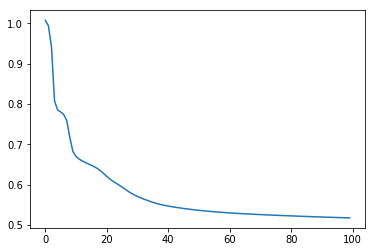

In [119]:
plt.plot(costs)